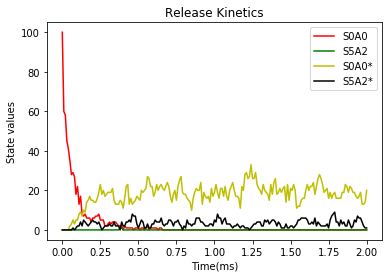

In [3]:
#This model of Synaptotagmin has been adapted from Nadkarni et., al(2010). The model defines the kinetics of Calcium sensor 
#with two pathways, synchronous (represented as S) and asynchronous (represented as A). The synchronous release pathway
#has 5 binding site whereas the asynchronous release pathway has 2 binding site. The neurotransmitter release process has
#distinct rates such as Gamma for synchronous release and a*Gamma for asynchronous release.

from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import numba
import multiprocessing
import seaborn as sns
import scipy.stats as st

Ca = 2e-06 #uM

#Defining the matrix for reactions involved in the model
#Rows indicate the reactants and products. Negative 1 indicates the decrease in the population of that particular state
#whereas Positive 1 indicates the increment in the state. Colums denote the total number of reactions involved in the
#model.

simple_update = np.array([[-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     #S0A0--->S1A0
                         [1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A0--->S0A0
                         [0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A0--->S2A0
                         [0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A0--->S1A0
                         [0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A0--->S3A0
                         [0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A0--->S2A0
                         [0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A0--->S4A0
                         [0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A0--->S3A0
                         [0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A0--->S5A0
                         [0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A0--->S4A0
                         [-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A1--->S0A0
                         [1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A0--->S0A1
                         [0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A1--->S1A0
                         [0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A1--->S1A1
                         [0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A1--->S2A0
                         [0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A0--->S2A1
                         [0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A1--->S3A0
                         [0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A0--->S3A1
                         [0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A1--->S4A0
                         [0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A0--->S4A1
                         [0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A1--->S5A0
                         [0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A0--->S5A1
                         [0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A1--->S1A1
                         [0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A1--->S0A1
                         [0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A1--->S2A1
                         [0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A1--->S1A1
                         [0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A1--->S3A1
                         [0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A1--->S2A1
                         [0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A1--->S4A1
                         [0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A1--->S3A1
                         [0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A1--->S5A1
                         [0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A1--->S4A1
                         [0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A2--->S0A1
                         [0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A1--->S0A2
                         [0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A2--->S1A1
                         [0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A1--->S1A2
                         [0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A2--->S2A1
                         [0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A1--->S2A2
                         [0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A2--->S3A1
                         [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A1--->S3A2
                         [0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A2--->S4A1
                         [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A1--->S4A2
                         [0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A2--->S5A1
                         [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A1--->S5A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A2--->S1A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A2--->S0A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A2--->S2A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A2--->S1A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A2--->S3A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A2--->S2A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A2--->S4A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A2--->S3A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A2--->S5A2
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A2--->S4A2
                         [-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A0--->S0A0*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A0*--->S0A0
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A0*--->S0A0
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A0*--->S0A0
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A0*--->S0A0
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A0*--->S0A0
                         [0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A0--->S5A0*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0],      #S5A0*--->S0A0
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0],      #S0A1*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],      #S5A1--->S5A1*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0],      #S5A1*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],      #S0A2--->S0A2*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0],      #S0A2*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],      #S1A2--->S1A2*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0],      #S1A2*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],      #S2A2--->S2A2*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0],      #S2A2*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],      #S3A2--->S3A2*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0],      #S3A2*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],      #S4A2--->S4A2*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0],      #S4A2*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],      #S5A2--->S5A2*
                         [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1],      #S5A2*--->S0A0
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S0A0*--->S1A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A0*--->S0A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S1A0*--->S2A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A0*--->S1A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S2A0*--->S3A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A0*--->S2A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S3A0*--->S4A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A0*--->S3A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0],      #S4A0*--->S5A0*
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,1],
                         [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1]], dtype=np.int)

def simple_propensity(params, population):
    # Unpacking parameters i.e rates involved in a reaction
    ks_plus,ks_minus,ka_plus,ka_minus,b,gamma,delta,epsilon,a = params
    
    # Unpacking population i.e the states of the synaptotagmin model
    S0A0,S1A0,S2A0,S3A0,S4A0,S5A0,S0A1,S1A1,S2A1,S3A1,S4A1,S5A1,S0A2,S1A2,S2A2,S3A2,S4A2,S5A2,S0A0_s,S1A0_s,S2A0_s,S3A0_s,S4A0_s,S5A0_s,S0A1_s,S1A1_s,S2A1_s,S3A1_s,S4A1_s,S5A1_s,S0A2_s,S1A2_s,S2A2_s,S3A2_s,S4A2_s,S5A2_s= population
    
    return np.array([5*ks_plus*S0A0*Ca,
                     ks_minus*S1A0,
                     4*ks_plus*S1A0*Ca,
                     2*b*ks_minus*S2A0,
                     3*ks_plus*S2A0*Ca,
                     3*b**2*ks_minus*S3A0,
                     2*ks_plus*S3A0*Ca,
                     4*b**3*ks_minus*S4A0,
                     ks_plus*S4A0*Ca,
                     5*b**4*ks_minus*S5A0,
                     2*ka_plus*S0A0*Ca,
                     ka_minus*S0A1,
                     2*ka_plus*S1A0*Ca,
                     ka_minus*S1A1,
                     2*ka_plus*S2A0*Ca,
                     ka_minus*S2A1,
                     2*ka_plus*S3A0*Ca,
                     ka_minus*S3A1,
                     2*ka_plus*S4A0*Ca,
                     ka_minus*S4A1,
                     2*ka_plus*S5A0*Ca,
                     ka_minus*S5A1,
                     5*ks_plus*S0A1*Ca,
                     ks_minus*S1A1,
                     4*ks_plus*S1A1*Ca,
                     2*b*ks_minus*S2A1,
                     3*ks_plus*S2A1*Ca,
                     3*b**2*ks_minus*S3A1,
                     2*ks_plus*S3A1*Ca,
                     4*b**3*ks_minus*S4A1,
                     ks_plus*S4A1*Ca,
                     5*b**4*ks_minus*S5A1,
                     ka_plus*S0A1*Ca,
                     2*ka_minus*S0A2,
                     ka_plus*S1A1*Ca,
                     2*ka_minus*S1A2,
                     ka_plus*S2A1*Ca,
                     2*ka_minus*S2A2,
                     ka_plus*S3A1*Ca,
                     2*ka_minus*S3A2,
                     ka_plus*S4A1*Ca,
                     2*ka_minus*S4A2,
                     ka_plus*S5A1*Ca,
                     2*ka_minus*S5A2,
                     5*ks_plus*S0A2*Ca,
                     ks_minus*S1A2,
                     4*ks_plus*S1A2*Ca,
                     2*b*ks_minus*S2A2,
                     3*ks_plus*S2A2*Ca,
                     3*b**2*ks_minus*S3A2,
                     2*ks_plus*S3A2*Ca,
                     4*b**3*ks_minus*S4A2,
                     ks_plus*S4A2*Ca,
                     5*b**4*ks_minus*S5A2,
                     delta*S0A0,
                     epsilon*S0A0_s,
                     epsilon*S1A0_s,
                     epsilon*S2A0_s,
                     epsilon*S3A0_s,
                     epsilon*S4A0_s,
                     gamma*S5A0,
                     epsilon*S5A0_s,
                     epsilon*S0A1_s,
                     gamma*S5A1,
                     epsilon*S5A1_s,
                     a*gamma*S0A2,
                     epsilon*S0A2_s,
                     a*gamma*S1A2,
                     epsilon*S1A2_s,
                     a*gamma*S2A2,
                     epsilon*S2A2_s,
                     a*gamma*S3A2,
                     epsilon*S3A2_s,
                     a*gamma*S4A2,
                     epsilon*S4A2_s,
                     (a*gamma*S5A2+delta*S5A2),
                     epsilon*S5A2_s,
                     5*ks_plus*S0A0_s*Ca,
                     ks_minus*S1A0_s,
                     4*ks_plus*S1A0_s*Ca,
                     2*b*ks_minus*S2A0_s,
                     3*ks_plus*S2A0_s*Ca,
                     3*b**2*ks_minus*S3A0_s,
                     2*ks_plus*S3A0_s*Ca,
                     4*b**3*ks_minus*S4A0_s,
                     ks_plus*S4A0_s*Ca,
                     5*b**4*ks_minus*S5A0_s,
                     2*ka_plus*S0A0_s*Ca,
                     ka_minus*S0A1_s,
                     2*ka_plus*S1A0_s*Ca,
                     ka_minus*S1A1_s,
                     2*ka_plus*S2A0_s*Ca,
                     ka_minus*S2A1_s,
                     2*ka_plus*S3A0_s*Ca,
                     ka_minus*S3A1_s,
                     2*ka_plus*S4A0_s*Ca,
                     ka_minus*S4A1_s,
                     2*ka_plus*S5A0_s*Ca,
                     ka_minus*S5A1_s,
                     5*ks_plus*S0A1_s*Ca,
                     ks_minus*S1A1_s,
                     4*ks_plus*S1A1_s*Ca,
                     2*b*ks_minus*S2A1_s,
                     3*ks_plus*S2A1_s*Ca,
                     3*b**2*ks_minus*S3A1_s,
                     2*ks_plus*S3A1_s*Ca,
                     4*b**3*ks_minus*S4A1_s,
                     ks_plus*S4A1_s*Ca,
                     5*b**4*ks_minus*S5A1_s,
                     ka_plus*S0A1_s*Ca,
                     2*ka_minus*S0A2_s,
                     ka_plus*S1A1_s*Ca,
                     2*ka_minus*S1A2_s,
                     ka_plus*S2A1_s*Ca,
                     2*ka_minus*S2A2_s,
                     ka_plus*S3A1_s*Ca,
                     2*ka_minus*S3A2_s,
                     ka_plus*S4A1_s*Ca,
                     2*ka_minus*S4A2_s,
                     ka_plus*S5A1_s*Ca,
                     2*ka_minus*S5A2_s,
                     5*ks_plus*S0A2_s*Ca,
                     ks_minus*S1A2_s,
                     4*ks_plus*S1A2_s*Ca,
                     2*b*ks_minus*S2A2_s,
                     3*ks_plus*S2A2_s*Ca,
                     3*b**2*ks_minus*S3A2_s,
                     2*ks_plus*S3A2_s*Ca,
                     4*b**3*ks_minus*S4A2_s,
                     ks_plus*S4A2_s*Ca,
                     5*b**4*ks_minus*S5A2_s])

def sample_discrete(probs):
    # Generate random number
    q = np.random.rand()
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

# Function to draw time interval and choice of reaction
def gillespie_draw(params, propensity_func, population):
    # Compute propensities
    props = propensity_func(params, population)
    # Sum of propensities
    props_sum = props.sum()
    # Compute time
    time = -np.log(np.random.uniform(0,1))/props_sum
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    return rxn, time

def gillespie_ssa(params, propensity_func, update, population_0, time_points):
    # Initialize output
    pop_out = np.empty((len(time_points), update.shape[1]), dtype=np.int)
    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    while(i<len(time_points)):
        while(t<time_points[i_time]):
            # draw the event and time step
            event, dt = gillespie_draw(params, propensity_func, population)
            # Update the population
            population_previous = population.copy()
            population += update[event,:]
            # Increment time
            t += dt
        # Update the index
        i = np.searchsorted(time_points > t, True)
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        # Increment index
        i_time = i
    return pop_out

# Initialising the rates 
params = np.array([0.612e08,2.32e03,3.82e06,13,0.25,2e03,0.417e-03,6.34e-03,0.025])
#simulation time
time_points = np.arange(0.0,2.01,0.01)
#Initialising population
population_0 = np.array([100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#number of simulations
n_simulations = 10

# Initialize output array
pops = np.empty((n_simulations, len(time_points), 36))

# Run the calculations
for i in range(n_simulations):
    pops[i,:,:] = gillespie_ssa(params, simple_propensity, simple_update,population_0, time_points)
    
#plotting the output
plt.plot(time_points,pops[i,:,0],'r',label="S0A0")
plt.plot(time_points,pops[i,:,17],'g',label="S5A2")
plt.plot(time_points,pops[i,:,18],'y',label="S0A0*")
plt.plot(time_points,pops[i,:,35],'k',label="S5A2*")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Kinetics")
plt.legend()
plt.show()

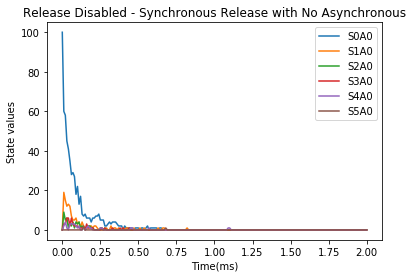

In [4]:
plt.plot(time_points,pops[i,:,0],label="S0A0")
plt.plot(time_points,pops[i,:,1],label="S1A0")
plt.plot(time_points,pops[i,:,2],label="S2A0")
plt.plot(time_points,pops[i,:,3],label="S3A0")
plt.plot(time_points,pops[i,:,4],label="S4A0")
plt.plot(time_points,pops[i,:,5],label="S5A0")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Disabled - Synchronous Release with No Asynchronous")
plt.legend()
plt.show()

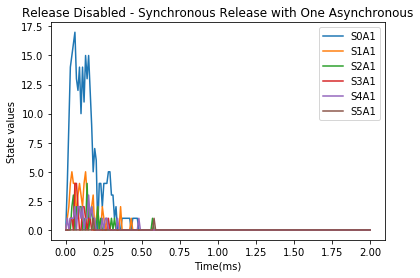

In [5]:
plt.plot(time_points,pops[i,:,6],label="S0A1")
plt.plot(time_points,pops[i,:,7],label="S1A1")
plt.plot(time_points,pops[i,:,8],label="S2A1")
plt.plot(time_points,pops[i,:,9],label="S3A1")
plt.plot(time_points,pops[i,:,10],label="S4A1")
plt.plot(time_points,pops[i,:,11],label="S5A1")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Disabled - Synchronous Release with One Asynchronous")
plt.legend()
plt.show()

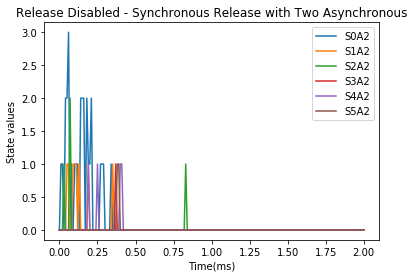

In [6]:
plt.plot(time_points,pops[i,:,12],label="S0A2")
plt.plot(time_points,pops[i,:,13],label="S1A2")
plt.plot(time_points,pops[i,:,14],label="S2A2")
plt.plot(time_points,pops[i,:,15],label="S3A2")
plt.plot(time_points,pops[i,:,16],label="S4A2")
plt.plot(time_points,pops[i,:,17],label="S5A2")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Disabled - Synchronous Release with Two Asynchronous")
plt.legend()
plt.show()

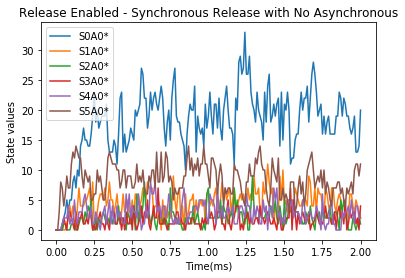

In [7]:
plt.plot(time_points,pops[i,:,18],label="S0A0*")
plt.plot(time_points,pops[i,:,19],label="S1A0*")
plt.plot(time_points,pops[i,:,20],label="S2A0*")
plt.plot(time_points,pops[i,:,21],label="S3A0*")
plt.plot(time_points,pops[i,:,22],label="S4A0*")
plt.plot(time_points,pops[i,:,23],label="S5A0*")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Enabled - Synchronous Release with No Asynchronous")
plt.legend()
plt.show()

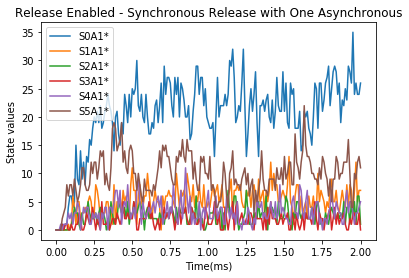

In [8]:
plt.plot(time_points,pops[i,:,24],label="S0A1*")
plt.plot(time_points,pops[i,:,25],label="S1A1*")
plt.plot(time_points,pops[i,:,26],label="S2A1*")
plt.plot(time_points,pops[i,:,27],label="S3A1*")
plt.plot(time_points,pops[i,:,28],label="S4A1*")
plt.plot(time_points,pops[i,:,29],label="S5A1*")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Enabled - Synchronous Release with One Asynchronous")
plt.legend()
plt.show()

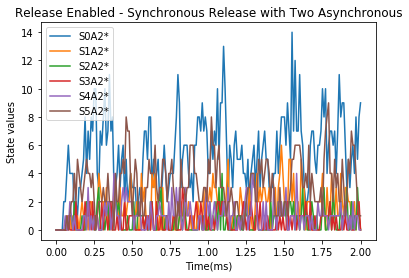

In [9]:
plt.plot(time_points,pops[i,:,30],label="S0A2*")
plt.plot(time_points,pops[i,:,31],label="S1A2*")
plt.plot(time_points,pops[i,:,32],label="S2A2*")
plt.plot(time_points,pops[i,:,33],label="S3A2*")
plt.plot(time_points,pops[i,:,34],label="S4A2*")
plt.plot(time_points,pops[i,:,35],label="S5A2*")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Enabled - Synchronous Release with Two Asynchronous")
plt.legend()
plt.show()

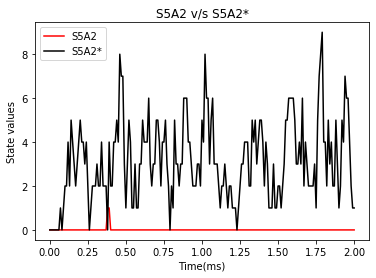

In [10]:
plt.plot(time_points,pops[i,:,17],'r',label="S5A2")
plt.plot(time_points,pops[i,:,35],'k',label="S5A2*")
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("S5A2 v/s S5A2*")
plt.legend()
plt.show()

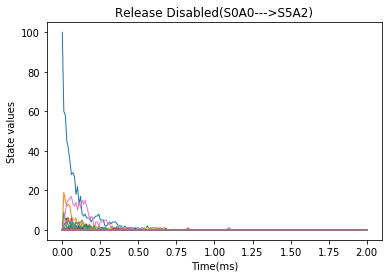

In [11]:
for j in range(18):
    plt.plot(time_points,pops[i,:,j],label=str(j), lw=1)
    
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Disabled(S0A0--->S5A2)")
plt.show()

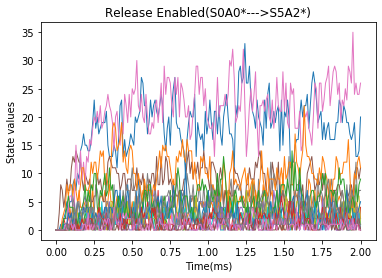

In [12]:
for j in range(18,36):
    plt.plot(time_points,pops[i,:,j],label=str(j), lw=1)
    
plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Release Enabled(S0A0*--->S5A2*)")
#plt.xlim(-0.1,1)
#plt.ylim(-0.1,2)
plt.show()

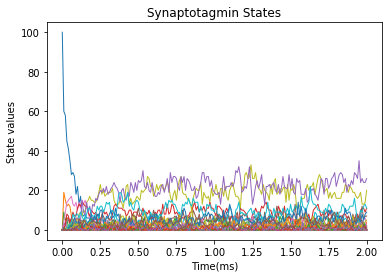

In [13]:
for j in range(36):
    plt.plot(time_points,pops[i,:,j],label=str(j), lw=1)

plt.xlabel("Time(ms)")
plt.ylabel("State values")
plt.title("Synaptotagmin States")
plt.show()